# Mustererkennung in Funkmessdaten

## Aufgabe 1: Laden der Datenbank in Jupyter Notebook

In [179]:
# imports
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pprint as pp

Wir öffnen die Datenbank und lassen uns die Keys der einzelnen Tabellen ausgeben. 
 

In [180]:
hdf = pd.HDFStore('../../data/raw/TestMessungen_NEU.hdf')
print(hdf.keys)

<bound method HDFStore.keys of <class 'pandas.io.pytables.HDFStore'>
File path: ../../data/raw/TestMessungen_NEU.hdf
/x1/t1/trx_1_2            frame        (shape->[227,12009])
/x1/t1/trx_1_4            frame        (shape->[229,12009])
/x1/t1/trx_2_3            frame        (shape->[226,12009])
/x1/t1/trx_3_1            frame        (shape->[233,12009])
/x1/t1/trx_3_4            frame        (shape->[226,12009])
/x1/t1/trx_4_2            frame        (shape->[230,12009])
/x1/t2/trx_1_2            frame        (shape->[223,12009])
/x1/t2/trx_1_4            frame        (shape->[220,12009])
/x1/t2/trx_2_3            frame        (shape->[218,12009])
/x1/t2/trx_3_1            frame        (shape->[221,12009])
/x1/t2/trx_3_4            frame        (shape->[218,12009])
/x1/t2/trx_4_2            frame        (shape->[221,12009])
/x1/t3/trx_1_2            frame        (shape->[246,12009])
/x1/t3/trx_1_4            frame        (shape->[250,12009])
/x1/t3/trx_2_3            frame        (sha

## Aufgabe 2: Inspektion eines einzelnen Dataframes

Wir laden den Frame x1_t1_trx_1_4 und betrachten seine Dimension. 

In [181]:
df_x1_t1_trx_1_4 = hdf.get('/x1/t1/trx_1_4')
print("Rows:", df_x1_t1_trx_1_4.shape[0])
print("Columns:", df_x1_t1_trx_1_4.shape[1])

Rows: 229
Columns: 12009


Als nächstes Untersuchen wir exemplarisch für zwei Empfänger-Sender-Gruppen die Attributzusammensetzung.

In [182]:
# first inspection of columns from df_x1_t1_trx_1_4
df_x1_t1_trx_1_4.head(5)

,index,Timestamp,trx_1_4_ifft_0,trx_1_4_ifft_1,trx_1_4_ifft_2,trx_1_4_ifft_3,trx_1_4_ifft_4,trx_1_4_ifft_5,trx_1_4_ifft_6,trx_1_4_ifft_7,...,trx_4_1_ifft_1992,trx_4_1_ifft_1993,trx_4_1_ifft_1994,trx_4_1_ifft_1995,trx_4_1_ifft_1996,trx_4_1_ifft_1997,trx_4_1_ifft_1998,trx_4_1_ifft_1999,trx_4_1_ts,target
0,0,1.492291e+09,0.021636,0.021845,0.022040,0.022221,0.022388,0.022540,0.022677,0.022798,...,0.013412,0.012879,0.012468,0.012188,0.012047,0.012049,0.012190,0.012462,1.488963e+12,"Empty_0.0,0.0_0.0,0.0"
1,1,1.492291e+09,0.020806,0.020952,0.021081,0.021192,0.021287,0.021363,0.021422,0.021462,...,0.015530,0.015678,0.015933,0.016286,0.016729,0.017254,0.017849,0.018505,1.488963e+12,"Empty_0.0,0.0_0.0,0.0"
2,2,1.492291e+09,0.030507,0.030675,0.030819,0.030940,0.031038,0.031111,0.031160,0.031184,...,0.010804,0.010567,0.010535,0.010708,0.011072,0.011607,0.012286,0.013082,1.488963e+12,"Empty_0.0,0.0_0.0,0.0"
3,3,1.492291e+09,0.027926,0.028066,0.028187,0.028288,0.028369,0.028430,0.028470,0.028489,...,0.018073,0.017580,0.017163,0.016826,0.016573,0.016408,0.016331,0.016341,1.488963e+12,"Empty_0.0,0.0_0.0,0.0"
4,4,1.492291e+09,0.021023,0.021285,0.021528,0.021752,0.021956,0.022141,0.022305,0.022449,...,0.016200,0.016055,0.016017,0.016085,0.016256,0.016524,0.016882,0.017323,1.488963e+12,"Empty_0.0,0.0_0.0,0.0"


Für die Analyse der Frames definieren wir einige Hilfsfunktionen.

In [183]:
# Little function to retrieve sender-receiver tuples from df columns
def extract_snd_rcv(df):
    regex = r"trx_[1-4]_[1-4]"
    # creates a set containing the different pairs
    snd_rcv = {x[4:7] for x in df.columns if re.search(regex, x)}
    return [(x[0],x[-1]) for x in snd_rcv]

In [184]:
# Sums the number of columns for each sender-receiver tuple
def get_column_counts(snd_rcv, df):
    col_counts = {}
    for snd,rcv in snd_rcv:
        col_counts['Columns for pair {} {}:'.format(snd, rcv)] = len([i for i, word in enumerate(list(df.columns)) if word.startswith('trx_{}_{}'.format(snd, rcv))])
    return col_counts

In [185]:
# Analyze the column composition of a given measurement.
def analyse_columns(df):
    df_snd_rcv = extract_snd_rcv(df)
    cc = get_column_counts(df_snd_rcv, df)

    for x in cc:
        print(x, cc[x])
    print("Sum of pair related columns: %i" % sum(cc.values()))
    print()
    print("Other columns are:")
    for att in [col for col in df.columns if 'ifft' not in col and 'ts' not in col]:
        print(att)

In [186]:
# Analyze the values of the target column.
def analyze_target(df):
    print(df['target'].unique())
    print("# Unique values in target: %i" % len(df['target'].unique()))

Bestimme nun die Spaltezusammensetzung von df_x1_t1_trx_1_4.

In [187]:
analyse_columns(df_x1_t1_trx_1_4)

Columns for pair 2 4: 2001
Columns for pair 1 4: 2001
Columns for pair 3 4: 2001
Columns for pair 2 1: 2001
Columns for pair 4 1: 2001
Columns for pair 3 1: 2001
Sum of pair related columns: 12006

Other columns are:
index
Timestamp
target


Betrachte den Inhalt der "target"-Spalte von df_x1_t1_trx_1_4.

In [188]:
analyze_target(df_x1_t1_trx_1_4)

['Empty_0.0,0.0_0.0,0.0' 'Standing_1.0,1.0_1.0,1.0' 'Step_1.0,1.0_1.0,2.0'
 'Standing_1.0,2.0_1.0,2.0' 'Step_1.0,2.0_2.0,2.0'
 'Standing_2.0,2.0_2.0,2.0' 'Step_2.0,2.0_2.0,1.0'
 'Standing_2.0,1.0_2.0,1.0' 'Step_2.0,1.0_1.0,1.0'
 'Walking_0.0,0.0_0.0,0.0']
# Unique values in target: 10


Als nächstes laden wir den Frame x3_t2_trx_3_1 und betrachten seine Dimension. 

In [189]:
df_x3_t2_trx_3_1 = hdf.get('/x3/t2/trx_3_1')
print("Rows:", df_x3_t2_trx_3_1.shape[0])
print("Columns:", df_x3_t2_trx_3_1.shape[1])

Rows: 247
Columns: 12009


Gefolgt von einer Analyse seiner Spaltenzusammensetzung und seiner "target"-Werte.

In [190]:
analyse_columns(df_x3_t2_trx_3_1)

Columns for pair 2 3: 2001
Columns for pair 2 1: 2001
Columns for pair 4 1: 2001
Columns for pair 3 1: 2001
Columns for pair 4 3: 2001
Columns for pair 1 3: 2001
Sum of pair related columns: 12006

Other columns are:
index
Timestamp
target


In [191]:
analyze_target(df_x3_t2_trx_3_1)

['Empty_0.0,0.0_0.0,0.0' 'Standing_1.0,1.0_1.0,1.0' 'Step_1.0,1.0_1.0,2.0'
 'Standing_1.0,2.0_1.0,2.0' 'Step_1.0,2.0_2.0,2.0'
 'Standing_2.0,2.0_2.0,2.0' 'Step_2.0,2.0_2.0,1.0'
 'Standing_2.0,1.0_2.0,1.0' 'Step_2.0,1.0_1.0,1.0'
 'Walking_0.0,0.0_0.0,0.0']
# Unique values in target: 10


Frage: Was stellen Sie bzgl. der „Empfänger-Nummer_Sender-Nummer“-Kombinationen fest? Sind diese gleich? Welche Ausprägungen finden Sie in der Spalte „target“? 

Antwort: Wir sehen, wenn jeweils ein Paar sendet, hören die anderen beiden Sender zu und messen ihre Verbindung zu den gerade sendenden Knoten (d.h. 6 Paare in jedem Dataframe). Sendet z.B. das Paar 3 1, so misst Knoten 1 die Verbindung 1-3, Knoten 3 die Verbindung 3-1 und Knoten 2 und 4 Verbindung 2-1 und 2-3 bzw. 4-1 und 4-3. Die 10 verschiedenen Ausprägungen der Spalte "target" sind oben zu sehen.

## Aufgabe 3: Visualisierung der Messreihe des Datensatz

Wir visualisieren die Rohdaten mit verschiedenen Heatmaps, um so die Integrität der Daten optisch zu validieren und Ideen für mögliche Features zu entwickeln. Hier stellen wir exemplarisch die Daten von Frame df_x1_t1_trx_1_4 dar.

In [192]:
vals = df_x1_t1_trx_1_4.loc[:,'trx_2_4_ifft_0':'trx_2_4_ifft_1999'].values

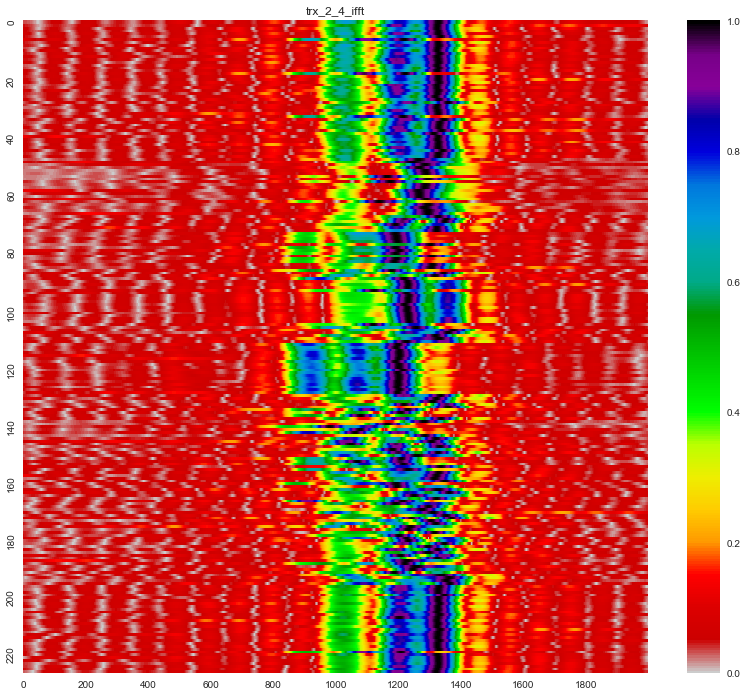

In [199]:
# one big heatmap
plt.figure(figsize=(14, 12))
plt.title('trx_2_4_ifft')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='nipy_spectral_r')
plt.show()

Wir betrachten wie verschiedene Farbschemata unterschiedliche Merkmale unserer Rohdaten hervorheben.

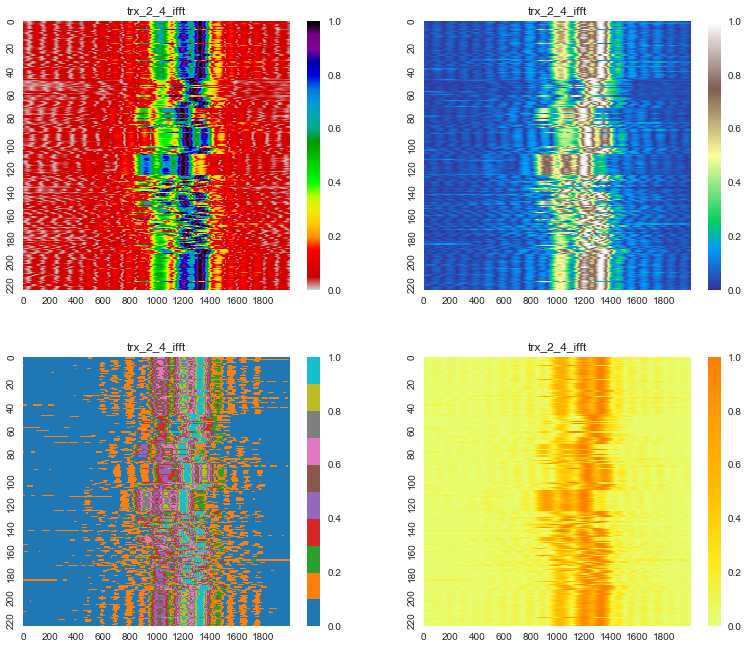

In [201]:
# compare different heatmaps
plt.figure(1, figsize=(12,10))

# nipy_spectral_r scheme
plt.subplot(221)
plt.title('trx_2_4_ifft')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='nipy_spectral_r')

# terrain scheme
plt.subplot(222)
plt.title('trx_2_4_ifft')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='terrain')

# Vega10 scheme
plt.subplot(223)
plt.title('trx_2_4_ifft')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='Vega10')

# Wistia scheme
plt.subplot(224)
plt.title('trx_2_4_ifft')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='Wistia')

# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.2)


plt.show()

## Aufgabe 3: Groundtruth-Label anpassen

In [202]:
# Iterating over hdf data and creating interim data presentation stored in data/interim/testmessungen_interim.hdf
# Interim data representation contains aditional binary class (binary_target - encoding 0=empty and 1=not empty)
# and multi class target (multi_target - encoding 0-9 for each possible class)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

interim_path = '../../data/interim/01_testmessungen.hdf'

def binary_mapper(df):
    
    def map_binary(target):
        if target.startswith('Empty'):
            return 0
        else:
            return 1
    
    df['binary_target'] = pd.Series(map(map_binary, df['target']))
    
    
def multiclass_mapper(df):
    le.fit(df['target'])
    df['multi_target'] = le.transform(df['target'])
    
for key in hdf.keys():
    df = hdf.get(key)
    binary_mapper(df)
    multiclass_mapper(df)
    df.to_hdf(interim_path, key)

hdf.close()

Überprüfe neu beschrifteten Dataframe „/x1/t1/trx_3_1“ verwenden. Wir erwarten als Ergebnisse für 5 zu Beginn des Experiments „Empty“ (bzw. 0) und für 120 mitten im Experiment „Not Empty“ (bzw. 1). 

In [208]:
hdf = pd.HDFStore('../../data/interim/01_testmessungen.hdf')
df_x1_t1_trx_3_1 = hdf.get('/x1/t1/trx_3_1')
print("binary_target for measurement 5:", df_x1_t1_trx_3_1['binary_target'][5])
print("binary_target for measurement 120:", df_x1_t1_trx_3_1['binary_target'][120])
hdf.close()

binary_target for measurement 5: 0
binary_target for measurement 120: 1


## Aufgabe 4: Einfacher Erkenner mit Hold-Out-Validierung